In [ ]:
!python -m ensurepip --upgrade
!python -m pip install --upgrade pip
!python -m pip install --upgrade papermill
!python -m pip install cartopy regionmask netCDF4 cmocean

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cmocean
import numpy as np
import cmocean as cmo
import pandas as pd
import regionmask
import cartopy.crs as ccrs
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from datetime import date

In [3]:
nombre = 'Javier Matos'
fecha = date.today()
fecha_formateada = fecha.strftime('%d de %B de %Y')
nombre_salida= 'Proyecto_Final_OceanHackWeek'

print(f'Este informe ha sido realizado por {nombre} y ejecutado en fecha {fecha_formateada}\n')
print(f'Consiste en un analisis de la temperatura en la Bahia de Samana entre los años 2022 y 2025')

Este informe ha sido realizado por Javier Matos y ejecutado en fecha 16 de October de 2025

Consiste en un analisis de la temperatura en la Bahia de Samana entre los años 2022 y 2025


In [4]:
data = xr.open_dataset('cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m_1760548338825.nc')

In [5]:
sst= data['thetao'][:]

**Extraccion de Coordenadas**

In [6]:
lon = sst.longitude
lat= sst.latitude

**Extraccion de data para graficarla**

# **Graficar Area de la data**

**Remover la data que cae sobre tierra la tierra**

In [7]:
tierra= regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(lon, lat)
data_masked= data.where(tierra.isnull())

**Elegir periodo a graficar**

In [8]:
print('El dataset se observa de esta manera:')
print(data_masked)

El dataset se observa de esta manera:
<xarray.Dataset> Size: 54MB
Dimensions:    (time: 1114, depth: 13, latitude: 28, longitude: 33)
Coordinates:
  * time       (time) datetime64[ns] 9kB 2022-10-07 2022-10-08 ... 2025-10-24
  * depth      (depth) float32 52B 0.494 1.541 2.646 3.819 ... 15.81 18.5 21.6
  * latitude   (latitude) float32 112B 17.58 17.67 17.75 ... 19.67 19.75 19.83
  * longitude  (longitude) float32 132B -69.92 -69.83 -69.75 ... -67.33 -67.25
Data variables:
    thetao     (time, depth, latitude, longitude) float32 54MB 29.46 ... 29.32
Attributes:
    Conventions:       CF-1.11
    title:             daily mean fields from Global Ocean Physics Analysis a...
    institution:       Mercator Ocean International
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    source:            MOI GLO12
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           https://marine.copernicus.eu/contact
    references:        http:

In [9]:
temp = data_masked['thetao']

In [10]:
print('La temperatura maxima es {}'.format(temp.max()))
print('La temperatura maxima es {}'.format(temp.min()))

La temperatura maxima es <xarray.DataArray 'thetao' ()> Size: 4B
array(31.938414, dtype=float32)
La temperatura maxima es <xarray.DataArray 'thetao' ()> Size: 4B
array(25.163874, dtype=float32)


In [11]:
temp_superficie = temp.sel(depth=0.49, method= 'nearest')
data_promedio = temp_superficie.mean(dim='time')

**Grafica de Zona de estudio**

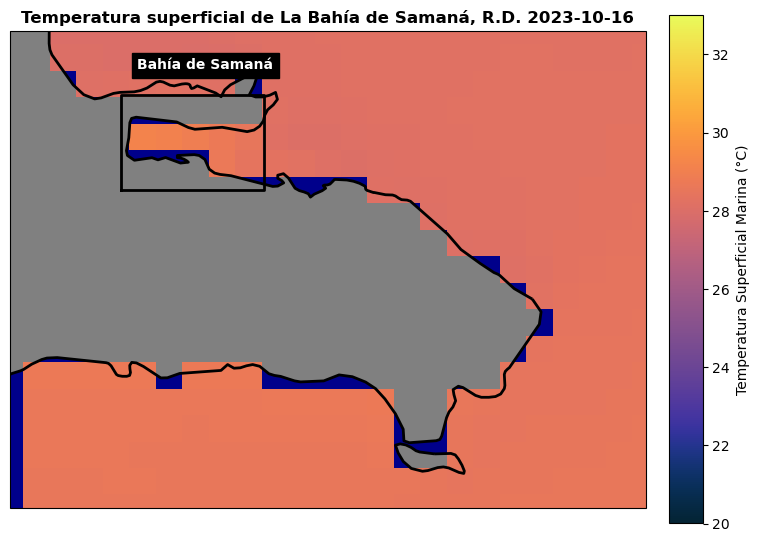

In [12]:
fig = plt.figure(figsize=(10,11))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
mesh = ax.pcolormesh(
    lon, lat, data_promedio ,
    transform=ccrs.PlateCarree(),
    cmap=cmo.cm.thermal,
    vmin=20, vmax=33,
    shading='nearest'
)
ax.coastlines(resolution='10m', color='black', linewidth=2)
ax.add_feature(cfeature.LAND, facecolor='gray')
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.OCEAN, facecolor= 'darkblue')
ax.set_extent([-70.0, -68.0, 18.0, 19.5], crs=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.03,
                    aspect=15, shrink=0.6)
# coordenadas para encerrar en un recuadro a la Bahia de Samana
lon_min = -69.65
lon_max = -69.2
lat_min = 19.0
lat_max = 19.3
lons = [lon_min, lon_min, lon_max, lon_max, lon_min]
lats = [lat_min, lat_max, lat_max, lat_min, lat_min]
ax.plot(lons, lats, color= 'k', linewidth= 2,
        transform= ccrs.PlateCarree())
ax.text(lon_min + 0.05, lat_max + 0.08, 'Bahía de Samaná',
        color= 'white', fontsize= 10, fontweight= 'bold',
        bbox= dict(facecolor= 'black', edgecolor='black'),
        transform= ccrs.PlateCarree())

cbar.set_label('Temperatura Superficial Marina (°C)')
ax.set_title('Temperatura superficial de La Bahía de Samaná, R.D. 2023-10-16', fontweight='bold')
plt.show()

# **Analisis Temporal de la Temperatura**

**Corte de pixels con data de temperatura. Se extrajeron unicamente los pixeles del área de interés**

In [13]:
lat_min = 19.0
lat_max = 19.3
lon_min = -69.5
lon_max = -69.0
bahia_samana = temp_superficie.sel(
    latitude=slice(lat_min, lat_max),
    longitude=slice(lon_min, lon_max)
)

In [14]:
sst_media = bahia_samana.mean(dim=['latitude','longitude'])

**Grafica de Evolucion de la temperatura en la Bahia de Samana a traves del Tiempo**

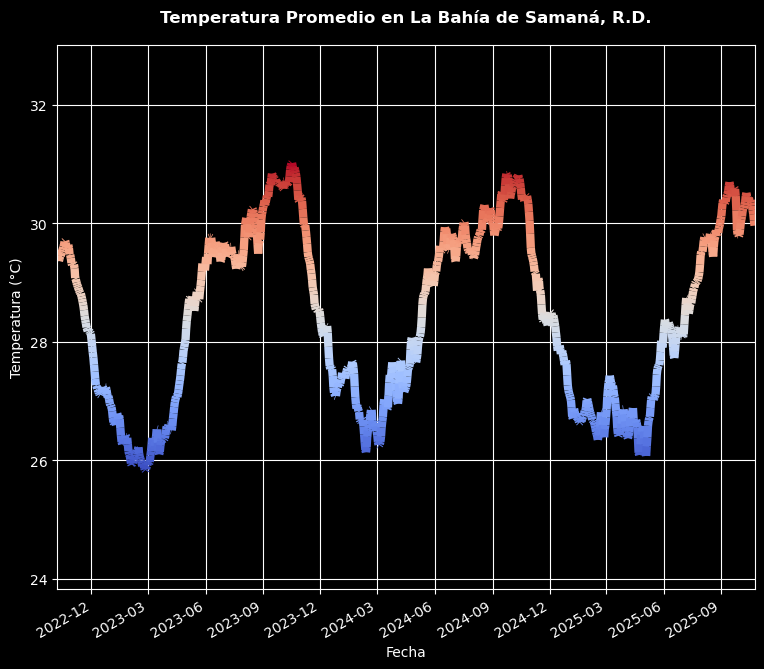

In [15]:
plt.style.use('dark_background')

temperaturas = sst_media.values

tiempo = sst_media.time.values
fechas= mdates.date2num(tiempo)

puntos = np.array([fechas, temperaturas]).T.reshape(-1, 1, 2)

segmentos= np.concatenate([puntos[:-1], puntos[1:]], axis= 1)

normal= plt.Normalize(temperaturas.min(), temperaturas.max())

coleccion = LineCollection(segmentos, cmap= 'coolwarm', norm= normal)

coleccion.set_array((temperaturas[:-1] + temperaturas[1:]) / 2)
coleccion.set_linewidth(6)

fig, ax =  plt.subplots(figsize = (9, 8))
ax.add_collection(coleccion)
ax.set_xlim(fechas.min(), fechas.max())

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

ax.set_ylim(temperaturas.min() - 2, temperaturas.max() + 2)

ax.set_title('Temperatura Promedio en La Bahía de Samaná, R.D.', fontweight= 'bold',
             pad= 16)
ax.set_xlabel('Fecha')
ax.set_ylabel('Temperatura (°C)')
ax.grid(True)
plt.show()

In [16]:
print(f'Se puede observar una considerable variabilidad entre los meses de verano e invierno para el hemisferio norte, donde la temperatura fluctua de {round((temp.max() - temp.min()).item(), 1)}')

Se puede observar una considerable variabilidad entre los meses de verano e invierno para el hemisferio norte, donde la temperatura fluctua de 6.8


In [17]:
import subprocess
nombre_salida = "Proyecto_Final_OceanHackWeek"  # nombre correcto del archivo sin extensión
command = f'jupyter nbconvert --to html --no-input --no-prompt "{nombre_salida}.ipynb" --output "{nombre_salida}.html"'
subprocess.run(command, shell=True, check=True)

[NbConvertApp] Converting notebook Proyecto_Final_OceanHackWeek.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 446344 bytes to Proyecto_Final_OceanHackWeek.html


CompletedProcess(args='jupyter nbconvert --to html --no-input --no-prompt "Proyecto_Final_OceanHackWeek.ipynb" --output "Proyecto_Final_OceanHackWeek.html"', returncode=0)

In [18]:
from IPython.display import FileLink
display(FileLink("Proyecto_Final_OceanHackWeek.html"))

/home/jovyan/Data/An-lisis-Oceanogr-fico-Bah-a-de-Saman-/Proyecto_Final_OceanHackWeek.html

In [19]:
ls -lh


total 70M
drwxr-xr-x. 2 jovyan jovyan    6 Oct 16 12:40 'Data Proyecto Final'/
-rw-r--r--. 1 jovyan jovyan 436K Oct 16 14:38  Proyecto_Final_OceanHackWeek.html
-rw-r--r--. 1 jovyan jovyan 177K Oct 16 15:21  Proyecto_Final_OceanHackWeek.ipynb
-rw-r--r--. 1 jovyan jovyan  299 Oct 16 12:39  README.md
-rw-r--r--. 1 jovyan jovyan  52M Oct 16 15:34  cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m_1760548338825.nc
-rw-r--r--. 1 jovyan jovyan 4.8M Oct 16 12:39  cmems_mod_glo_phy_anfc_0.083deg_PT1H-m_1760198079272.nc
